# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections. This Notebook is divided en the following sections.

1. Prerequisites
2. 3 Day Rolling Window
    -  Freeman Segregation Index
    - Spectral Segregation Index
3. Daily
4. Conclusion 


## 1. Prerequistes

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool as gt
from graph_tool.spectral import adjacency

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
from glob import glob
from tqdm import tqdm

For the calculation od the segregation Indexes, we define some notation based on (Bojanowski & Corten 2014).

We define a Graph with $$\mathbb{N}= \{1, \dots, i, \dots, N\}$$ and then, define the set $$\mathbb{G} = \{G_1, G_2,\dots, G_k\}$$ as the set of $K$ groups in which every $G_g$ is a subset of $\mathbb{N}$ that contains all the nodes that belong to group $g$. 

Now we define the type vector as $$\textbf{t} = [t_1,\dots, t_i, \dots, t_N]$$ where $t_i \in \{1,\dots,K\}$. This vector matches every node with its corresponding group. Using this notation. We can define a type indicator vector for each group $k$ as follows:  $$\textbf{v}_k = [v_1, \dots, v_i, \dots, v_N]$$ where $v_i \in \{0,1\}$. This vector has one entry for every node and the node location will have a 1 if that node corresponds to the group $G_k$. Formally:

$$ v_i = \begin{cases} 1 &\text{ if }t_i = k \\ 0 &\text{ if }t_i \neq k \end{cases} $$

Now we define the Types Matrix $T_{N\times K}$ as a matrix that contains the information of each node and wich group it represents. For Every column of the matrix corresponds to a $\textbf{v}_k$ _types indicator vector_.

For representing our graph we relate nodes using a symetric relationship $R$ over $\mathbb{N} \times \mathbb{N}$ in which

$$iRj \leftrightarrow x_{ij} = x_{ji} \neq 0$$

For this Reseach, the Adjacency Matrix $X$ will have the amount of Retweets $i$ has with $j$ and vice versa

In [3]:
# Load Types Matrix
data = np.load('/mnt/disk2/Data/Matrices/Useful_Matrices/types_matrix.npz')
indices = data['indices']
indptr = data['indptr']
shape = data['shape']
data = data['data']
types = sp.csr_matrix((data, indices, indptr), shape = shape)
print(f'There are {types.shape[0]} nodes and {types.shape[1]} Groups')

# Load Types DF
types_df = pd.read_pickle('/mnt/disk2/Data/Pickle/types_indicator_df.pkl')

# Load user_indices file for filtering
with open('/mnt/disk2/Data/Pickle/user_indices.pkl', 'rb') as file:
    user_indices = pickle.load(file)

There are 37337 nodes and 4 Groups


In [4]:
# We explore our group Data types matrix looks like this
N, K = types.shape
Eta_k = []
for k in range(K):
    Eta = np.sum(types[:,k])
    Eta_k.append(Eta)
Eta_k = np.array(Eta_k)

# Print the Amounts
print(f'Tweets de Derecha: {Eta_k[0]}')
print(f'Tweets de Izquierda: {Eta_k[1]}')
print(f'Tweets de Centro: {Eta_k[2]}')
print(f'No Retweets: {Eta_k[3]}')

Tweets de Derecha: 6812
Tweets de Izquierda: 23138
Tweets de Centro: 3543
No Retweets: 3844


In [5]:
def freeman(adj: np.array, types: np.array) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

    Returns:
        type: Segregation Index of Freeman

    """
    # We get the amount of vertices and groups
    N, K = types.shape
    
    # Get the amount of nodes per group
    Eta_k =[]
    for k in range(K):
        Eta = np.sum(types[:, k])
        Eta_k.append(Eta)
    Eta_k = np.array(Eta_k)
    
    # Calculate the contact layer Corresponds to the number of relation between and within groups acoording to the groups indexes
    M = types.transpose().dot(adj).dot(types)
    M = M.toarray()
    M = np.triu(M)
    M_no_diag = np.triu(M,k=1)

    # Calculate P 
    P = M_no_diag.sum() / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (Eta_k.sum() **2) - (np.sum(Eta_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

In [6]:
def Spectral_Segregation_Index(adj: np.array, types: pd.DataFrame, user_indices: dict) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

        user_indices (Dict): a Python Dictionary in which the keys are user IDs and the values are the index of that 
        user in the adjacency matrix

    Returns:
        type: Segregation Index of Freeman

    """

    results = {}

    # Normalize adjacency
    row_sums = adj.sum(axis=1).A.ravel()
    R = adj / row_sums[:, np.newaxis]
    R = R.tocsr()

    # Get the group Indexes
    columns = list(types_df.columns)
    columns.pop(1)
    for i in columns:
        users = types_df[types_df[i] == 1].index

        # get the filter for the Adjcacency
        filter = []
        for user in users:
            filter.append(user_indices[user])
        filter

        # Get group subMatrix
        ixgrid = np.ix_(filter,filter)
        C = R[ixgrid]
        C = C.toarray()

        # Get Max EigenValue
        SSI_C = np.linalg.eig(C)
        SSI_value = max(SSI_C.eigenvalues, key = lambda x: x.real).real

        # Store Results
        results['Group'] = i
        results[i] = [SSI_value]
        
        final = pd.DataFrame(results)

    # Output
    return final

## 2. 3 Day rolling window Segregation Indexes

### 1. Freeman Segregation Index

In [7]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')

# Store results
data_viz = []

for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    #Appending it to the data Visualization list
    data = {
        'date': [adjacency_name],
        'segregation_freeman': [freeman(adj,types)]
    }
    df = pd.DataFrame(data, index = None)
    data_viz.append(df)

# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%d-%m-%Y')

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


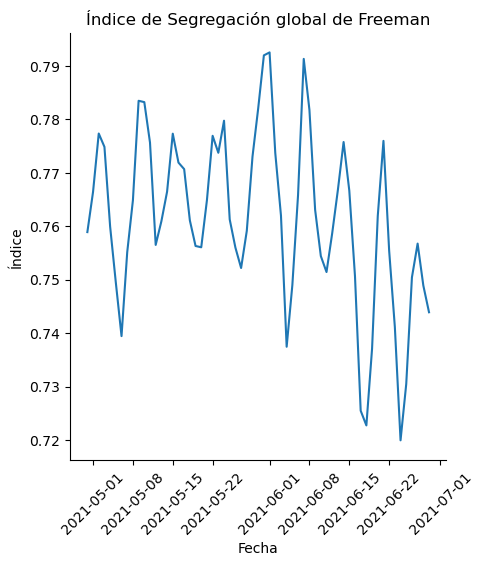

In [8]:
# Figure Mapping
sns.relplot(data = data_viz,
            x ='date',
            y = 'segregation_freeman',
            kind = 'line')

# Labels
plt.title('Índice de Segregación global de Freeman')
plt.ylabel('Índice')
plt.xlabel('Fecha')

# Others
plt.xticks(rotation=45)
plt.show()

### 2. Spectral Segregation Index

In [9]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
data_viz = []

# This takes a While XD (runtime: 1 Hour aprox)
for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    data = Spectral_Segregation_Index(adj,types,user_indices)
    data['date'] = adjacency_name

    #Appending it to the data Visualization list
    data_viz.append(data)

# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%d-%m-%Y')

# Pivot to long format
data_viz = pd.melt(data_viz,
                    id_vars=['date'],
                    value_vars=['Dummy Derecha', 'Dummy Centro', 'No Retweets'], var_name='Group', value_name='segregation')

print("DataFrame in long format:")
data_viz.head()

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divid

DataFrame in long format:


,date,Group,segregation
0,2021-05-26,Dummy Derecha,1.0
1,2021-06-03,Dummy Derecha,1.0
2,2021-05-05,Dummy Derecha,1.0
3,2021-05-09,Dummy Derecha,1.0
4,2021-06-24,Dummy Derecha,1.0


In [13]:
np.min(data_viz.segregation)

1.0

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


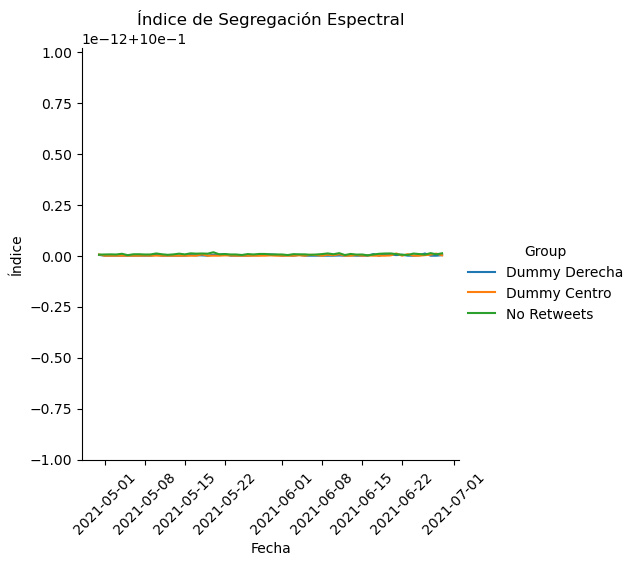

In [10]:
# Figure Mapping
sns.relplot(data = data_viz,
            x ='date',
            y = 'segregation',
            kind = 'line',
            hue = 'Group')

# Labels
plt.title('Índice de Segregación Espectral')
plt.ylabel('Índice')
plt.xlabel('Fecha')

# Others
plt.xticks(rotation=45)
plt.show()